# Import the necessary library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
from tqdm import tqdm

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = (
    torch.device(f"cuda:{torch.cuda.current_device()}")
    if torch.cuda.is_available()
    else "cpu"
)
torch.set_default_device(device)

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Create custom dataset that combines two images into one
class CombineDataset(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CombineDataset, self).__init__(root, train, transform, target_transform, download)
        self.data, self.targets = self.combine_images(self.data, self.targets)

    def combine_images(self, data, targets):
        new_data = []
        new_targets = []
        # Combine two random images
        for i in range(len(data) // 2):
            img1 = data[i]
            img2 = data[i + 1]
            new_img = torch.zeros(1, 28, 56)
            new_img[0, :, :28] = img1 / 255.0
            new_img[0, :, 28:] = img2 / 255.0
            new_data.append(new_img)
            new_targets.append(targets[i] * 10 + targets[i + 1])
        # Convert the list to tensor
        new_data = torch.stack(new_data)
        new_targets = torch.tensor(new_targets)
        return new_data, new_targets

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.data)

# Create Dataloader

In [ ]:
# Create the DataLoader
batch_size = 128
train_dataset = CombineDataset(root="~/Desktop/data", train=True, download=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.6MB/s]


Extracting /root/Desktop/data/CombineDataset/raw/train-images-idx3-ubyte.gz to /root/Desktop/data/CombineDataset/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.26MB/s]


Extracting /root/Desktop/data/CombineDataset/raw/train-labels-idx1-ubyte.gz to /root/Desktop/data/CombineDataset/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting /root/Desktop/data/CombineDataset/raw/t10k-images-idx3-ubyte.gz to /root/Desktop/data/CombineDataset/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.31MB/s]


Extracting /root/Desktop/data/CombineDataset/raw/t10k-labels-idx1-ubyte.gz to /root/Desktop/data/CombineDataset/raw



# Show the samples from the data loader

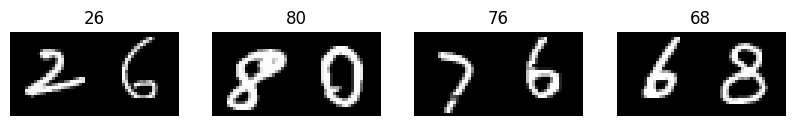

In [ ]:
# Show 4 samples from the dataloader
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axs[i].imshow(images[i].squeeze().numpy(), cmap="gray")
    axs[i].set_title(labels[i].item())
    axs[i].axis("off")
plt.show()

# Implementation of Real NVP

# Define Real NVP model

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask = mask

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Scale limited to [-1, 1]
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, reverse=False):
        masked_x = x * self.mask
        scale = self.scale_net(masked_x) * (1 - self.mask)
        translate = self.translate_net(masked_x) * (1 - self.mask)

        if reverse:
            x = (x - translate) * torch.exp(-scale)
        else:
            x = x * torch.exp(scale) + translate

        log_det = torch.sum(scale, dim=1) if not reverse else -torch.sum(scale, dim=1)
        return x, log_det

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_coupling_layers):
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.coupling_layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            mask = torch.arange(input_dim) % 2 == (i % 2)  # Alternating binary mask
            mask = mask.float().to(device)
            self.coupling_layers.append(CouplingLayer(input_dim, hidden_dim, mask))

    def forward(self, x, reverse=False):
        log_det = 0
        if reverse:
            for layer in reversed(self.coupling_layers):
                x, ld = layer(x, reverse=True)
                log_det += ld
        else:
            for layer in self.coupling_layers:
                x, ld = layer(x)
                log_det += ld
        return x, log_det

# Train the model and plot the training loss

Epoch 1/10: 100%|██████████| 235/235 [02:18<00:00,  1.69it/s]


Epoch [1/10], Loss: -3165.9874


Epoch 2/10: 100%|██████████| 235/235 [02:13<00:00,  1.76it/s]


Epoch [2/10], Loss: -3622.8305


Epoch 3/10: 100%|██████████| 235/235 [02:17<00:00,  1.71it/s]


Epoch [3/10], Loss: -3724.8461


Epoch 4/10: 100%|██████████| 235/235 [02:49<00:00,  1.39it/s]


Epoch [4/10], Loss: -3780.1314


Epoch 5/10: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]


Epoch [5/10], Loss: -3818.2617


Epoch 6/10: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]


Epoch [6/10], Loss: -3843.6338


Epoch 7/10: 100%|██████████| 235/235 [02:49<00:00,  1.39it/s]


Epoch [7/10], Loss: -3863.3689


Epoch 8/10: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]


Epoch [8/10], Loss: -3879.0836


Epoch 9/10: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]


Epoch [9/10], Loss: -3893.5220


Epoch 10/10: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]


Epoch [10/10], Loss: -3903.1568


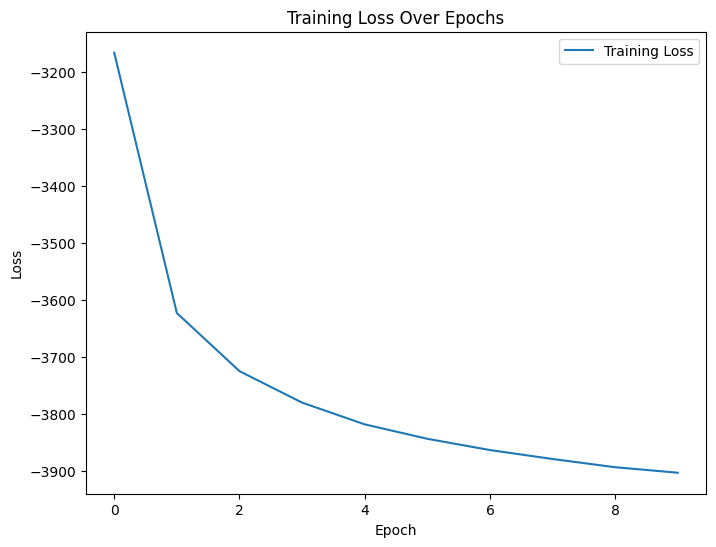

In [ ]:
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images = images.view(images.size(0), -1).to(device)  # Flatten images
            z, log_det = model(images)
            log_prob = -0.5 * torch.sum(z**2, dim=1)  # Log probability of Gaussian
            loss = -(log_prob + log_det).mean()  # Negative log likelihood

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        epoch_loss /= len(dataloader)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return loss_history

def plot_losses(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

# Initialize and train the model
input_dim = 28 * 56  # Flattened image dimension
hidden_dim = 512  # Hidden layer dimension
num_coupling_layers = 6  # Number of coupling layers

model = RealNVP(input_dim=input_dim, hidden_dim=hidden_dim, num_coupling_layers=num_coupling_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
loss_history = train_model(model, train_loader, optimizer, num_epochs=10)

# Plot the training losses
plot_losses(loss_history)

# Generate images using the trained model

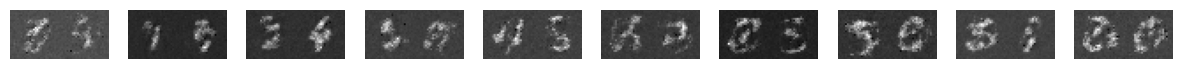

In [ ]:
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn((num_images, 28 * 56)).to(device)  # Sample from Gaussian
        generated_images, _ = model(z, reverse=True)
        generated_images = generated_images.view(num_images, 1, 28, 56).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        axs[i].imshow(generated_images[i].squeeze().numpy(), cmap="gray")
        axs[i].axis("off")
    plt.show()

# Generate and display images
generate_images(model, num_images=10)